# 행동 예측 모델

### 데이터 전처리

In [1]:
import pandas as pd

url = './data/freetips.level0.csv'

df_ori = pd.read_csv(url)
df = df_ori[:]
print('데이터 {} 개'.format(len(df)))
df.head()

데이터 19305 개


,_id,timestamp,cafe_id,seat,gender,act,group,menu
0,64ed854c241a11ac3221126c,2023-08-02T14:40:24.265Z,20,60.0,"{'male': 0, 'female': 0}",chatting,"{'average': 3.0, 'cluster': [4, 0, 2, 3, 0]}",ice
1,64ed854c241a11ac3221126d,2023-08-02T14:41:24.680Z,20,100.0,"{'male': 50.0, 'female': 50.0}",chatting,"{'average': 3.2, 'cluster': [4, 2, 2, 4, 4]}",ice
2,64ed854c241a11ac3221126e,2023-08-02T14:42:25.622Z,20,80.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.75, 'cluster': [4, 0, 2, 4, 1]}",ice
3,64ed854c241a11ac3221126f,2023-08-02T14:43:25.765Z,20,40.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.5, 'cluster': [4, 0, 2, 3, 1]}",ice
4,64ed854c241a11ac32211270,2023-08-02T14:44:26.528Z,20,60.0,"{'male': 20.0, 'female': 80.0}",chatting,"{'average': 3.5, 'cluster': [4, 0, 2, 4, 4]}",ice


In [2]:
df.dtypes

_id           object
timestamp     object
cafe_id        int64
seat         float64
gender        object
act           object
group         object
menu          object
dtype: object

## 데이터 프로파일
### 변수
1. _id
    - 고유값. ( 데이터에서 제거 )
2. timestamp
    - 2023-08-02, 14:40:24.265 
    - 날짜, 시간으로 분리
        - Real number로 변경: 230802
        - 시간 시 분 초
3. seat
    - Real number
    - 좌석 점유율 %
4. gender
    - 남여 성비 %
    - dict 구조. -> 남자 비율로 변경 
    - 여자비율 = 100 - 남자 비율
4. act
    - Categorical
    - 어떤 행동이 많이 있는지.
    - chatting, reading, working
5. group
    - 평균 몇명인지, 각 테이블 별로 몇명이 앉아 있는지.
6. menu
    - Categorical
    - 어떤 음료가 많이 팔리는지
    - hot, ice

### 행동 예측에 필요
- 요일별로 예측 할 때 필요
    - cafe_id, day, seat
- 시간별로 예측 할 때 필요
    - cafe_id, time, seat
- 연, 월, 일, 요일, 시간에 따른 행동 예측

In [4]:
act_occupancy_data = df[:].copy()
act_occupancy_data['date'] = pd.to_datetime(act_occupancy_data['timestamp'])
act_occupancy_data = act_occupancy_data.set_index('date')
act_occupancy_data['year'] = act_occupancy_data.index.year
act_occupancy_data['month'] = act_occupancy_data.index.month
act_occupancy_data['day'] = act_occupancy_data.index.day
act_occupancy_data['dayofweek'] = act_occupancy_data.index.dayofweek
act_occupancy_data['hour'] = act_occupancy_data.index.hour
act_occupancy_data['minute'] = act_occupancy_data.index.minute
act_occupancy_data['second'] = act_occupancy_data.index.second
act_occupancy_data['time'] = act_occupancy_data.index.time
act_occupancy_data['date'] = act_occupancy_data.index.date
act_occupancy_data['day'] = act_occupancy_data.index.day
act_occupancy_data.head()

,_id,timestamp,cafe_id,seat,gender,act,group,menu,year,month,day,dayofweek,hour,minute,second,time,date
date,,,,,,,,,,,,,,,,,
2023-08-02 14:40:24.265000+00:00,64ed854c241a11ac3221126c,2023-08-02T14:40:24.265Z,20,60.0,"{'male': 0, 'female': 0}",chatting,"{'average': 3.0, 'cluster': [4, 0, 2, 3, 0]}",ice,2023,8,2,2,14,40,24,14:40:24.265000,2023-08-02
2023-08-02 14:41:24.680000+00:00,64ed854c241a11ac3221126d,2023-08-02T14:41:24.680Z,20,100.0,"{'male': 50.0, 'female': 50.0}",chatting,"{'average': 3.2, 'cluster': [4, 2, 2, 4, 4]}",ice,2023,8,2,2,14,41,24,14:41:24.680000,2023-08-02
2023-08-02 14:42:25.622000+00:00,64ed854c241a11ac3221126e,2023-08-02T14:42:25.622Z,20,80.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.75, 'cluster': [4, 0, 2, 4, 1]}",ice,2023,8,2,2,14,42,25,14:42:25.622000,2023-08-02
2023-08-02 14:43:25.765000+00:00,64ed854c241a11ac3221126f,2023-08-02T14:43:25.765Z,20,40.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.5, 'cluster': [4, 0, 2, 3, 1]}",ice,2023,8,2,2,14,43,25,14:43:25.765000,2023-08-02
2023-08-02 14:44:26.528000+00:00,64ed854c241a11ac32211270,2023-08-02T14:44:26.528Z,20,60.0,"{'male': 20.0, 'female': 80.0}",chatting,"{'average': 3.5, 'cluster': [4, 0, 2, 4, 4]}",ice,2023,8,2,2,14,44,26,14:44:26.528000,2023-08-02


In [7]:
cafe_20 = act_occupancy_data[act_occupancy_data['cafe_id'] == 20][['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second', 'act']]
cafe_20_act_data = cafe_20[['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second']]
cafe_20_act_target = cafe_20[['act']]
cafe_20.head()

,year,month,day,dayofweek,hour,minute,second,act
date,,,,,,,,
2023-08-02 14:40:24.265000+00:00,2023,8,2,2,14,40,24,chatting
2023-08-02 14:41:24.680000+00:00,2023,8,2,2,14,41,24,chatting
2023-08-02 14:42:25.622000+00:00,2023,8,2,2,14,42,25,chatting
2023-08-02 14:43:25.765000+00:00,2023,8,2,2,14,43,25,chatting
2023-08-02 14:44:26.528000+00:00,2023,8,2,2,14,44,26,chatting


In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(cafe_20_act_target)
labels = encoder.transform(cafe_20_act_target)

/Users/kyungmin/opt/anaconda3/envs/iot/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kyungmin/opt/anaconda3/envs/iot/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [10]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

X_train, X_test, y_train, y_test = train_test_split(cafe_20_act_data, labels ,test_size=0.1)
xgb_model = xgboost.XGBRegressor(n_estimators=10000, learning_rate=0.04, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=3)

print(len(X_train), len(X_test))
xgb_model.fit(X_train,y_train)

3015 336


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [12]:
predictions = xgb_model.predict(X_test)
predictions

array([1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44, 1.7e-44,
       1.7e-44, 1.7e

In [13]:
r_sq = xgb_model.score(X_train, y_train)
print('성능 평가 점수: {}'.format(r_sq))
print('분산 회귀 점수: {}'.format(explained_variance_score(predictions,y_test)))

성능 평가 점수: 0.0
분산 회귀 점수: 1.0


In [14]:
X_pred = cafe_20_act_data
pred = xgb_model.predict(X_pred)
test = cafe_20_act_data[:].copy()
test['target'] = cafe_20_act_target['act']
test['pred'] = pred
test.head()

,year,month,day,dayofweek,hour,minute,second,target,pred
date,,,,,,,,,
2023-08-02 14:40:24.265000+00:00,2023,8,2,2,14,40,24,chatting,1.681558e-44
2023-08-02 14:41:24.680000+00:00,2023,8,2,2,14,41,24,chatting,1.681558e-44
2023-08-02 14:42:25.622000+00:00,2023,8,2,2,14,42,25,chatting,1.681558e-44
2023-08-02 14:43:25.765000+00:00,2023,8,2,2,14,43,25,chatting,1.681558e-44
2023-08-02 14:44:26.528000+00:00,2023,8,2,2,14,44,26,chatting,1.681558e-44


<Axes: xlabel='date'>

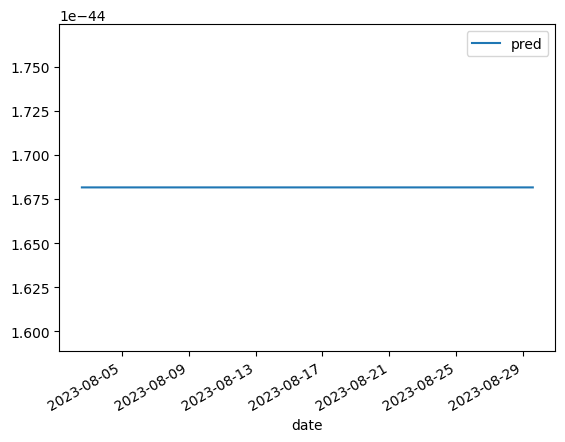

In [15]:
result = test[:]
# result = result.set_index('dayofweek')
result = result.loc[:, ['target', 'pred']]
result.plot()

In [17]:
import pickle 
with open('act_model.pickle','wb') as fw:
    pickle.dump(xgb_model, fw)

In [ ]:
import pickle 
with open('model_210519.pickle', 'rb') as f: 
    model = pickle.load(f)
    model()

In [19]:
import numpy as np

test = np.array([2023, 8, 2, 2, 14, 40 ,24])

In [24]:
print(X_pred.shape)

(3351, 7)


In [ ]:
X_pred = cafe_20_act_data
pred = xgb_model.predict(test)